In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import integrate, optimize, interpolate
from numba import njit

For this homework, I'm mostly adding slight modifications to the code from class. You can find the original code here: https://www.physics.rutgers.edu/grad/509/05_Atom_in_LDA.html

In [2]:
@njit
def Numerov(f, x0, dx, dh):
    """ Given precumputed function f(x) solved the differential equation
        x''(t) = f(t) x(t)
        input: x0 = x(t=0), and dx = dx/dt(t=0)
    """
    x = np.zeros(len(f))
    x[0] = x0
    x[1] = x0 + dh*dx
    h2 = dh**2
    h12 = h2/12.
    w0 = x0*(1-h12*f[0])
    w1 = x[1]*(1-h12*f[1])
    xi = x[1]
    fi = f[1]
    for i in range(2,len(f)):
        w2 = 2*w1-w0 + h2*fi*xi
        fi = f[i]
        xi = w2/(1-h12*fi)
        x[i]=xi
        (w0,w1) = (w1,w2)
    return x

@njit
def fShrod(En,l,R):
    return l*(l+1.)/R**2 - 2./R - En

def ComputeSchrod(En, R, l):
    f = fShrod(En,l,R[::-1])
    ur = Numerov(f, 0.0, -1e-7, -R[1]+R[0])[::-1]
    norm = integrate.simpson(ur**2, x=R)
    return ur/np.sqrt(abs(norm))
    
def Shoot(En, R, l):
    ur = ComputeSchrod(En, R, l)
    ur = ur/R**l  # expecting urn \propto R
    #f0,f1 = ur[0],ur[1]
    #f_at_0 = f0 + (f1-f0)*(0-R[0])/(R[1]-R[0]) # extrapolation to zero
    #return f_at_0
    #poly = polyfit(R[:4], ur[:4], deg=3)
    #return polyval(poly, 0.0)
    poly = np.polynomial.Polynomial.fit(R[:4], ur[:4], deg=3)
    return poly(0.0)        

def FindBoundStates(R, l, nmax, Esearch):
    n=0
    Ebnd=[]
    u0 = Shoot(Esearch[0],R,l)
    for i in range(1,len(Esearch)):
        u1 = Shoot(Esearch[i],R,l)
        if u0*u1 < 0:
            #print 'Sign change at', Esearch[i-1], Esearch[i]
            Ebound = optimize.brentq(Shoot,Esearch[i-1],Esearch[i],xtol=1e-15,args=(R,l))
            Ebnd.append( (l,Ebound) )
            if len(Ebnd)>nmax: break
            n += 1
            print('Found bound state at E=%14.9f' % Ebound)
        u0 = u1
    return Ebnd 

def cmpKey(x):
    return x[1]*1000 + x[0]  # energy has large wait, but degenerate energy states are sorted by l

def ChargeDensity(Bnd,R,Z):
    rho = np.zeros(len(R))
    N=0.
    for (l,En) in Bnd:
        ur = ComputeSchrod(En, R, l)
        dN = 2*(2*l+1)
        if N+dN <= Z:
            ferm = 1.
        else:
            ferm = (Z-N)/float(dN)
        drho = ur**2 * ferm * dN/(4*np.pi*R**2)
        rho += drho
        N += dN
        print('adding state', (l,En), 'with fermi=', ferm)
        if  N>=Z: break
    return rho

Found bound state at E=  -0.999999943
Found bound state at E=  -0.249999990
Found bound state at E=  -0.111111108
Found bound state at E=  -0.062499999
Found bound state at E=  -0.039999942
Found bound state at E=  -0.249999998
Found bound state at E=  -0.111111111
Found bound state at E=  -0.062500000
Found bound state at E=  -0.039999957
Found bound state at E=  -0.111111111
Found bound state at E=  -0.062500000
Found bound state at E=  -0.039999977
Found bound state at E=  -0.062500000
Found bound state at E=  -0.039999992
adding state (0, -0.9999999428189236) with fermi= 1.0
adding state (0, -0.2499999899816187) with fermi= 1.0
adding state (1, -0.2499999979714578) with fermi= 1.0
adding state (0, -0.11111110835536761) with fermi= 1.0
adding state (1, -0.11111111057681711) with fermi= 1.0
adding state (2, -0.1111111111469023) with fermi= 1.0


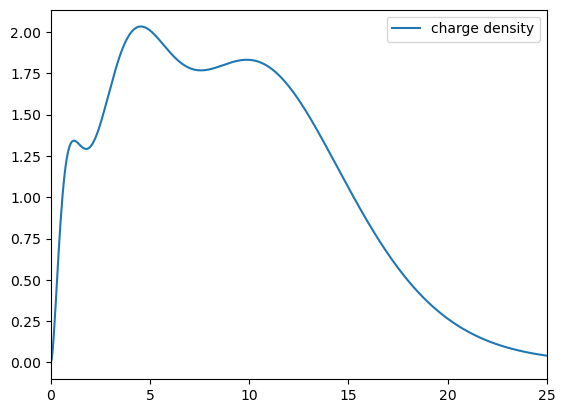

In [3]:
Esearch = -1.2/np.arange(1,20,0.2)**2
R = np.linspace(1e-6,100,2000)

Z=28
nmax = 5
Bnd=[]
for l in range(nmax-1):
    Bnd += FindBoundStates(R,l,nmax-l,Esearch)
Bnd = sorted(Bnd, key=cmpKey)

z = 28. # like Ni atom

rho = ChargeDensity(Bnd,R,Z)
        
plt.plot(R, rho*(4*np.pi*R**2), label='charge density')
plt.xlim([0,25])
plt.legend(loc='best')

In [4]:
def FuncForHartree(y,r,rhoSpline):
    """ y = [U,U']
        dy/dr = [U', -8*pi*r*rho(r)]
    """
    return [y[1], -8*np.pi*r*rhoSpline(r)]

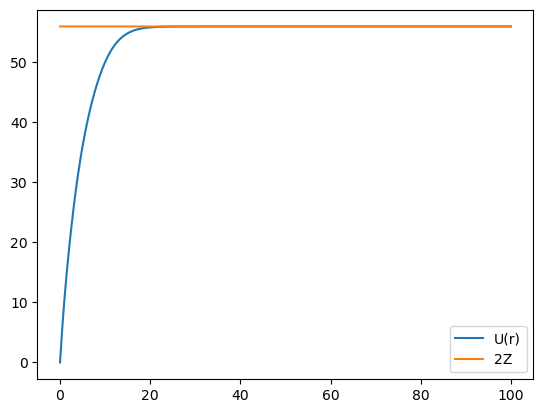

In [5]:
rhoSpline = interpolate.UnivariateSpline(R, rho,s=0)

U0 = integrate.odeint(FuncForHartree, [0.0,0.5], R, args=(rhoSpline,))[:,0]
alpha = (2*Z - U0[-1])/R[-1]
U0 += alpha * R

plt.plot(R, U0,label='U(r)')
plt.plot(R, np.ones(len(R))*2*Z, label='2Z')
plt.legend(loc='best')

In [6]:
@njit
def NumerovUP(U, x0, dx, dh):
    x = np.zeros(len(U))
    x[0] = x0
    x[1] = dx*dh + x0
    h2 = dh*dh
    h12 = h2/12
    w0 = x[0]-h12*U[0]
    w1 = x[1]-h12*U[1]
    Ui = U[1]
    for i in range(2,len(U)):
        w2 = 2*w1 - w0 + h2*Ui
        Ui = U[i]
        xi = w2 + h12*Ui
        x[i] = xi
        w0, w1 = w1, w2
    return x

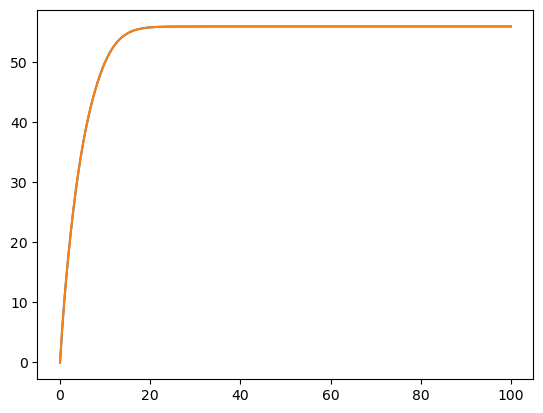

In [7]:
U2 = NumerovUP(-8*np.pi*R*rho, 0.0, 0.5, R[1]-R[0])
alpha2 = (2*Z-U2[-1])/R[-1]
U2 += alpha2 * R

plt.plot(R,U0)
plt.plot(R,U2)

In [8]:
def HartreeU(R, rho, Zatom):
    """Given input charge density it returns Hartree potential in the form VH(r)*r
    """
    U2 = NumerovUP(-8*np.pi*R*rho, 0.0, 0.5, R[1]-R[0])
    alpha2 = (2*Zatom-U2[-1])/R[-1]
    U2 += alpha2 * R
    return U2

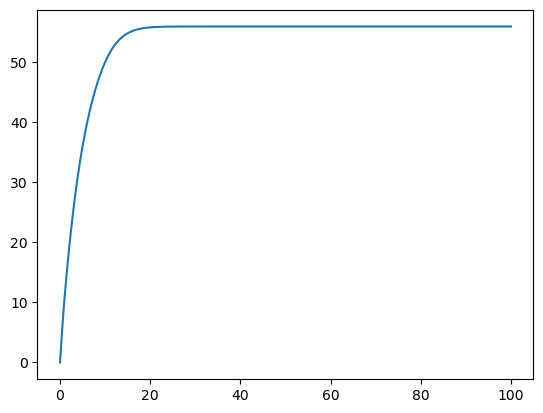

In [9]:
U2 = HartreeU(R,rho,Z)
plt.plot(R,U2)

In [10]:
from excor import ExchangeCorrelation
exc = ExchangeCorrelation()

@njit
def rs(rho):
    "1/rho = 4*pi*rs^3/3 => rs = (3/(4*pi*rho))**(1/3.)"
    if rho < 1e-100: return 1e100
    return pow(3/(4*np.pi*rho),1/3.)

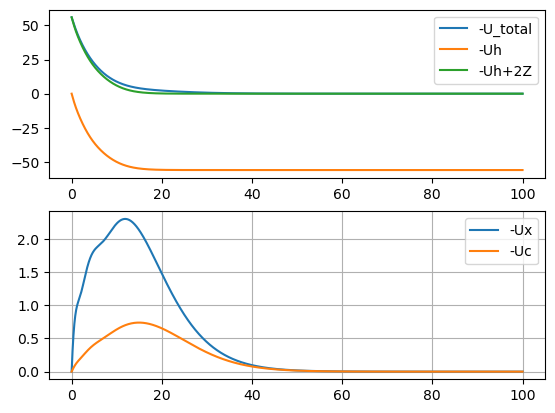

In [11]:
Vxc = np.array([2*exc.Vc(rs(rh)) + 2*exc.Vx(rs(rh)) for rh in rho])    # factor of 2 due to change of units from Hartree to Rydbers
Vx = np.array([2*exc.Vx(rs(rh)) for rh in rho])  
Vc = np.array([2*exc.Vc(rs(rh)) for rh in rho])
Uks = U2 - 2*Z + Vxc*R

fig,(ax1, ax2) = plt.subplots(2, 1)
ax1.plot(R, -Uks, label='-U_total');
ax1.plot(R, -U2, label='-Uh')
ax1.plot(R, -U2+2*Z, label='-Uh+2Z')
ax2.plot(R,-Vx*R,label='-Ux')
ax2.plot(R,-Vc*R,label='-Uc')
#ax2.plot(R,U2,label='Uh')
ax2.legend(loc='best')
ax1.legend(loc='best')
ax2.grid()

In [12]:
@njit
def fShrod(En,l,R, Uks):
    return (l*(l+1.)/R +Uks)/R - En

def ComputeSchrod(En, R, l, Uks):
    #f = fShrod(En,l,R[::-1],Uks[::-1])
    #ur = Numerov(f, 0.0, -1e-10, R[0]-R[1])[::-1]
    f = fShrod(En,l,R, Uks)
    ur = Numerov(f[::-1], 0.0, -1e-10, R[0]-R[1])[::-1]
    norm = integrate.simpson(ur**2, x=R)
    return ur/np.sqrt(abs(norm))

def Shoot(En, R, l, Uks):
    ur = ComputeSchrod(En, R, l,Uks)
    ur *= 1/R**l  # expecting urn \propto R
    #f0,f1 = ur[0],ur[1]
    #f_at_0 = f0 + (f1-f0)*(0-R[0])/(R[1]-R[0]) # extrapolation to zero
    #return f_at_0
    poly = np.polynomial.Polynomial.fit(R[:4], ur[:4], deg=3)
    return poly(0.0)

def FindBoundStates(R, l, nmax, Esearch, Uks):
    n=0
    Ebnd=[]
    u0 = Shoot(Esearch[0],R,l,Uks)
    for i in range(1,len(Esearch)):
        u1 = Shoot(Esearch[i],R,l,Uks)
        if u0*u1 < 0:
            Ebound = optimize.brentq(Shoot,Esearch[i-1],Esearch[i],xtol=1e-15,args=(R,l,Uks))
            Ebnd.append( (l,Ebound) )
            if len(Ebnd)>nmax: break
            n += 1
            print(f"Found bound state at E={Ebound/2:14.9f}H l={l:2d}")
        u0 = u1
    return Ebnd 

In [13]:
nmax=5

Bnd=[]
for l in range(nmax-1):
    Bnd += FindBoundStates(R,l,nmax-l,Esearch,Uks)
    
Bnd = sorted(Bnd, key=cmpKey)

Found bound state at E=  -0.301181700H l= 0
Found bound state at E=  -0.114301424H l= 0
Found bound state at E=  -0.034082204H l= 0
Found bound state at E=  -0.003612354H l= 0
Found bound state at E=  -0.313798778H l= 1
Found bound state at E=  -0.118616033H l= 1
Found bound state at E=  -0.034746947H l= 1
Found bound state at E=  -0.003345161H l= 1
Found bound state at E=  -0.300009838H l= 2
Found bound state at E=  -0.108653489H l= 2
Found bound state at E=  -0.028845107H l= 2
Found bound state at E=  -0.279116709H l= 3
Found bound state at E=  -0.093722034H l= 3


In [14]:
# This is modified from Hydrogen
def ChargeDensity(bst,R,Zatom,Uks):
    rho = np.zeros(len(R))
    N=0.
    Ebs=0.  # sum of all eigenvalues of KS equation.
    for (l,En) in bst:
        ur = ComputeSchrod(En, R, l, Uks)
        dN = 2*(2*l+1)
        if N+dN <= Zatom:
            ferm = 1.
        else:
            ferm = (Zatom-N)/float(dN)
        drho = ur**2 * ferm * dN/(4*np.pi*R**2)
        rho += drho
        N += dN
        Ebs += En * dN * ferm
        print('adding state', (l,En/2), 'H with fermi=', ferm)
        if  N>=Zatom: break
    return (rho,Ebs)

In [15]:
Z=28
rho_new, Ebs = ChargeDensity(Bnd,R,Z,Uks)

adding state (1, -0.3137987779463955) H with fermi= 1.0
adding state (0, -0.30118170042796616) H with fermi= 1.0
adding state (2, -0.30000983841183604) H with fermi= 1.0
adding state (3, -0.27911670884400286) H with fermi= 0.7142857142857143


(-76.8, 1.0)

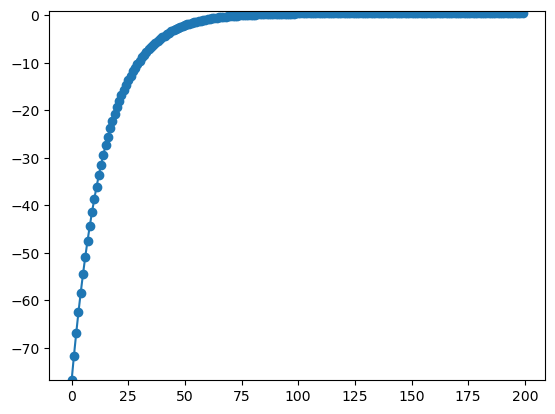

In [16]:
Zatom=8
E0=-1.2*Zatom**2
Eshift=0.5 # sometimes energies can be positive!!!                                                                                                                        
Esearch = -np.logspace(-4,np.log10(-E0+Eshift),200)[::-1] + Eshift
plt.plot(Esearch,'o-')
plt.ylim([-1.2*Zatom**2,1])

## Oxygen

Found bound state at E=  -0.500000000H l= 0
Found bound state at E=  -0.124987114H l= 0
Found bound state at E=  -0.049918048H l= 0
Found bound state at E=   0.016713154H l= 0
Found bound state at E=  -0.124994607H l= 1
Found bound state at E=  -0.051611420H l= 1
Found bound state at E=   0.008086683H l= 1
Found bound state at E=  -0.053967564H l= 2
Found bound state at E=  -0.005535033H l= 2
adding state (0, -0.5000000000000031) H with fermi= 1.0
adding state (0, -0.12498711431297786) H with fermi= 1.0
adding state (1, -0.12499460664692999) H with fermi= 0.6666666666666666
Total density has weight 8.0
Itteration 0 Etot[Ry]= -16.726051391754353 Etot[Hartre]= -8.363025695877177 Diff= 16.726051391754353
Found bound state at E= -29.405159055H l= 0
Found bound state at E=  -5.536091363H l= 0
Found bound state at E=  -1.468026473H l= 0
Found bound state at E=  -0.359111083H l= 0
Found bound state at E=  -5.489821269H l= 1
Found bound state at E=  -1.423825062H l= 1
Found bound state at E=  

(0.0, 5.0)

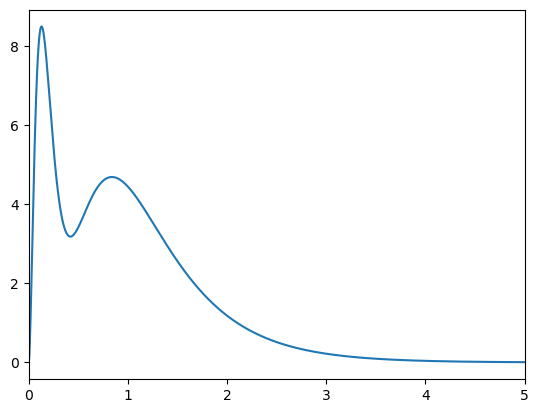

In [17]:
R = np.linspace(1e-8,20,2**14+1)
Zatom = 8 # 20  # 19
mixr = 0.5

E0=-1.2*Zatom**2
Eshift=0.5 # sometimes energies can be positive!!!                                                                                                                        
Esearch = -np.logspace(-4,np.log10(-E0+Eshift),200)[::-1] + Eshift
nmax = 4 #3

exc = ExchangeCorrelation()
Uks = -2*np.ones(len(R))
Eold = 0
Etol = 1e-7

for itt in range(1000):
    Bnd=[]
    for l in range(nmax-1):
        Bnd += FindBoundStates(R,l,nmax-l,Esearch,Uks)
    
    Bnd = sorted(Bnd, key=cmpKey)
    rho_new, Ebs = ChargeDensity(Bnd,R,Zatom,Uks)
    
    if itt==0:
        rho = rho_new
    else:
        rho = rho_new * mixr + (1-mixr)*rho_old
    rho_old = np.copy(rho)
    
    U2 = HartreeU(R, rho, Zatom)

    Vxc = [2*exc.Vc(rs(rh)) + 2*exc.Vx(rs(rh)) for rh in rho]   
    
    Uks = U2 - 2*Zatom + Vxc*R

    # Total energy
    ExcVxc = [2*exc.EcVc(rs(rh)) + 2*exc.ExVx(rs(rh)) for rh in rho]  # eps_xc(rho)-V_xc(rho)
    pot = (ExcVxc*R - 0.5*U2)*R*rho*4*np.pi                              # (eps_xc-V_xc-0.5 U_H/R)*rho * d^3r
    epot = integrate.simpson(pot, x=R)
    Etot = epot + Ebs
    
    print('Total density has weight', integrate.simpson(rho*(4*np.pi*R**2),x=R))
    #print('Total Energy=', Etot/2.)
    
    print('Itteration', itt, 'Etot[Ry]=', Etot, 'Etot[Hartre]=', Etot/2, 'Diff=', abs(Etot-Eold))

    
    if  itt>0 and abs(Etot-Eold)< Etol: break
    Eold = Etot
    
    #plot(R, U2, label='U-hartree')
    #plot(R, Vxc, label='Vxc')
    #plot(R, Uks, label='Uks')
    #show()
    
plt.plot(R,rho*(4*np.pi*R**2))
plt.xlim([0,5])

The Hartree energy is around -74.47307692937525 which is agrees well with NIST (-74.473077).

## Potassium

/var/folders/gl/qkjlxgd944l2rvbjy6m3dk900000gr/T/ipykernel_81676/1726350799.py:10: RuntimeWarning: overflow encountered in square
  norm = integrate.simpson(ur**2, x=R)
/opt/miniconda3/envs/rcphy/lib/python3.12/site-packages/scipy/integrate/_quadrature.py:526: RuntimeWarning: overflow encountered in multiply
  y[slice1] * (hsum *
/opt/miniconda3/envs/rcphy/lib/python3.12/site-packages/scipy/integrate/_quadrature.py:522: RuntimeWarning: overflow encountered in add
  tmp = hsum/6.0 * (y[slice0] *


Found bound state at E=  -0.500000000H l= 0
Found bound state at E=  -0.124987114H l= 0
Found bound state at E=  -0.049918048H l= 0
Found bound state at E=   0.016713154H l= 0
Found bound state at E=  -0.124994607H l= 1
Found bound state at E=  -0.051611420H l= 1
Found bound state at E=   0.008086683H l= 1
Found bound state at E=  -0.053967564H l= 2
Found bound state at E=  -0.005535033H l= 2
adding state (0, -0.5000000000000032) H with fermi= 1.0
adding state (0, -0.12498711431297754) H with fermi= 1.0
adding state (1, -0.12499460664692966) H with fermi= 1.0
adding state (2, -0.05396756442457265) H with fermi= 0.9
Total density has weight 19.0
Itteration 0 Etot[Ry]= -52.364679332462025 Etot[Hartre]= -26.182339666231012 Diff= 52.364679332462025
Found bound state at E= -40.956632672H l= 0
Found bound state at E= -16.003341111H l= 0
Found bound state at E=  -7.461141575H l= 0
Found bound state at E=  -3.689629815H l= 0
Found bound state at E= -40.952259648H l= 1
Found bound state at E= -

(0.0, 5.0)

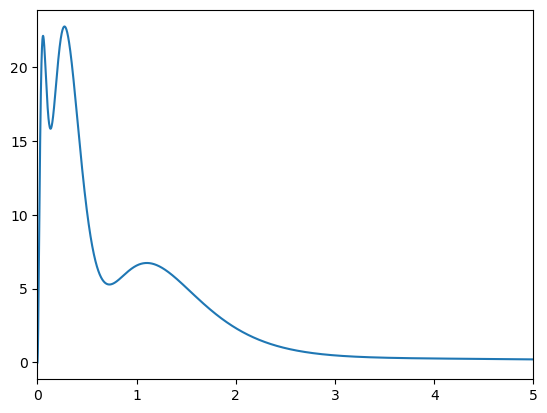

In [18]:
R = np.linspace(1e-8,20,2**14+1)
Zatom = 19 # 20  # 19
mixr = 0.5

E0=-1.2*Zatom**2
Eshift=0.5 # sometimes energies can be positive!!!                                                                                                                        
Esearch = -np.logspace(-4,np.log10(-E0+Eshift),200)[::-1] + Eshift
nmax = 4 #3

exc = ExchangeCorrelation()
Uks = -2*np.ones(len(R))
Eold = 0
Etol = 1e-7

for itt in range(1000):
    Bnd=[]
    for l in range(nmax-1):
        Bnd += FindBoundStates(R,l,nmax-l,Esearch,Uks)
    
    Bnd = sorted(Bnd, key=cmpKey)
    rho_new, Ebs = ChargeDensity(Bnd,R,Zatom,Uks)
    
    if itt==0:
        rho = rho_new
    else:
        rho = rho_new * mixr + (1-mixr)*rho_old
    rho_old = np.copy(rho)
    
    U2 = HartreeU(R, rho, Zatom)

    Vxc = [2*exc.Vc(rs(rh)) + 2*exc.Vx(rs(rh)) for rh in rho]   
    
    Uks = U2 - 2*Zatom + Vxc*R

    # Total energy
    ExcVxc = [2*exc.EcVc(rs(rh)) + 2*exc.ExVx(rs(rh)) for rh in rho]  # eps_xc(rho)-V_xc(rho)
    pot = (ExcVxc*R - 0.5*U2)*R*rho*4*np.pi                              # (eps_xc-V_xc-0.5 U_H/R)*rho * d^3r
    epot = integrate.simpson(pot, x=R)
    Etot = epot + Ebs
    
    print('Total density has weight', integrate.simpson(rho*(4*np.pi*R**2),x=R))
    #print('Total Energy=', Etot/2.)
    
    print('Itteration', itt, 'Etot[Ry]=', Etot, 'Etot[Hartre]=', Etot/2, 'Diff=', abs(Etot-Eold))

    
    if  itt>0 and abs(Etot-Eold)< Etol: break
    Eold = Etot
    
    #plot(R, U2, label='U-hartree')
    #plot(R, Vxc, label='Vxc')
    #plot(R, Uks, label='Uks')
    #show()
    
plt.plot(R,rho*(4*np.pi*R**2))
plt.xlim([0,5])

The answer we get for Potassium also agrees. NIST lists a value of -598.200590 for LDA, and we calculate -598.2005949485075.

## How far can we push it?

/var/folders/gl/qkjlxgd944l2rvbjy6m3dk900000gr/T/ipykernel_81676/1726350799.py:10: RuntimeWarning: overflow encountered in square
  norm = integrate.simpson(ur**2, x=R)


Found bound state at E=  -0.500000000H l= 0
Found bound state at E=  -0.124987114H l= 0
Found bound state at E=  -0.049918048H l= 0
Found bound state at E=   0.016713154H l= 0
Found bound state at E=  -0.124994607H l= 1
Found bound state at E=  -0.051611420H l= 1
Found bound state at E=   0.008086683H l= 1
Found bound state at E=  -0.053967564H l= 2
Found bound state at E=  -0.005535033H l= 2
adding state (0, -0.4999999999999949) H with fermi= 1.0
adding state (0, -0.1249871143129777) H with fermi= 1.0
adding state (1, -0.12499460664692999) H with fermi= 1.0
adding state (2, -0.053967564424572796) H with fermi= 1.0
adding state (1, -0.05161141976121452) H with fermi= 0.16666666666666666
Total density has weight 21.0
Itteration 0 Etot[Ry]= -60.51504421673813 Etot[Hartre]= -30.257522108369066 Diff= 60.51504421673813
Found bound state at E= -50.703462547H l= 0
Found bound state at E= -20.172800880H l= 0
Found bound state at E=  -9.662575723H l= 0
Found bound state at E=  -4.971829762H l= 

(0.0, 5.0)

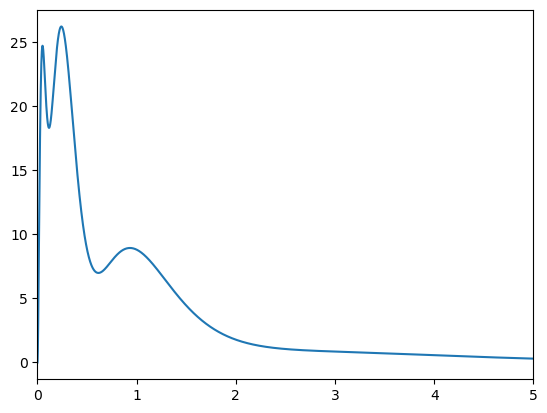

In [27]:
R = np.linspace(1e-8,20,2**14+1)
Zatom = 21
mixr = 0.5

E0=-1.2*Zatom**2
Eshift=0.5 # sometimes energies can be positive!!!                                                                                                                        
Esearch = -np.logspace(-4,np.log10(-E0+Eshift),200)[::-1] + Eshift
nmax = 4 #3

exc = ExchangeCorrelation()
Uks = -2*np.ones(len(R))
Eold = 0
Etol = 1e-7

for itt in range(1000):
    Bnd=[]
    for l in range(nmax-1):
        Bnd += FindBoundStates(R,l,nmax-l,Esearch,Uks)
    
    Bnd = sorted(Bnd, key=cmpKey)
    rho_new, Ebs = ChargeDensity(Bnd,R,Zatom,Uks)
    
    if itt==0:
        rho = rho_new
    else:
        rho = rho_new * mixr + (1-mixr)*rho_old
    rho_old = np.copy(rho)
    
    U2 = HartreeU(R, rho, Zatom)

    Vxc = [2*exc.Vc(rs(rh)) + 2*exc.Vx(rs(rh)) for rh in rho]   
    
    Uks = U2 - 2*Zatom + Vxc*R

    # Total energy
    ExcVxc = [2*exc.EcVc(rs(rh)) + 2*exc.ExVx(rs(rh)) for rh in rho]  # eps_xc(rho)-V_xc(rho)
    pot = (ExcVxc*R - 0.5*U2)*R*rho*4*np.pi                              # (eps_xc-V_xc-0.5 U_H/R)*rho * d^3r
    epot = integrate.simpson(pot, x=R)
    Etot = epot + Ebs
    
    print('Total density has weight', integrate.simpson(rho*(4*np.pi*R**2),x=R))
    #print('Total Energy=', Etot/2.)
    
    print('Itteration', itt, 'Etot[Ry]=', Etot, 'Etot[Hartre]=', Etot/2, 'Diff=', abs(Etot-Eold))

    
    if  itt>0 and abs(Etot-Eold)< Etol: break
    Eold = Etot
    
    #plot(R, U2, label='U-hartree')
    #plot(R, Vxc, label='Vxc')
    #plot(R, Uks, label='Uks')
    #show()
    
plt.plot(R,rho*(4*np.pi*R**2))
plt.xlim([0,5])

I tested this code for tin and zinc and the diagreements with NIST were large. Manganese seems to lead to an infinite loop where the algorithm can't converge. This issue seems to begin at $Z=22$. This is interesting to me because for $Z=21$, our implementation seems to agree fairly well with NIST. I believe this means we'd need to loosen the tolerance so that our loop can break, but this just reflects larger inaccuracies at higher $Z$. Ultimately, we want to make the algorithm more accurate. 